<a href="https://colab.research.google.com/github/warlords94/personal-coding/blob/main/big_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

In [2]:
train_ds,validation_ds = tfds.load(
    "tf_flowers" ,
    split = ["train[:85%]" ,"train[85%:]"],
    as_supervised=True
)

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


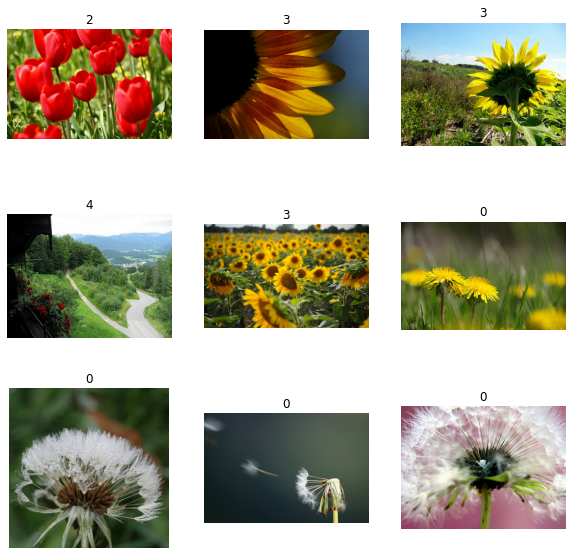

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
RESIZE_TO=384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH =10
AUTO = tf.data.AUTOTUNE
NUM_CLASSES =5
SCHEDULE_LENGTH = (500)
SCHEDULE_BOUNDARIES = [200,300,400]

In [5]:
SCHDEDULE_LENGTH = SCHEDULE_LENGTH *512 / BATCH_SIZE
@tf.function

def preprocess_train(image,label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.resize(image,(RESIZE_TO,RESIZE_TO))
  image = tf.image.random_crop(image,(CROP_TO,CROP_TO,3))
  image = image/255.0
  return (image,label)

@tf.function
def preprocess_test(image,label):
  image = tf.image.resize(image,(RESIZE_TO,RESIZE_TO))
  image = image/255.0
  return (image,label)

DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()
repeat_count = int(SCHDEDULE_LENGTH *BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH)

repeat_count+=50+1

In [6]:
pipeline_train = (
    train_ds.shuffle(1000).repeat(repeat_count).map(preprocess_train,num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO)
)

pipeline_validation = (validation_ds.map(preprocess_test,num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

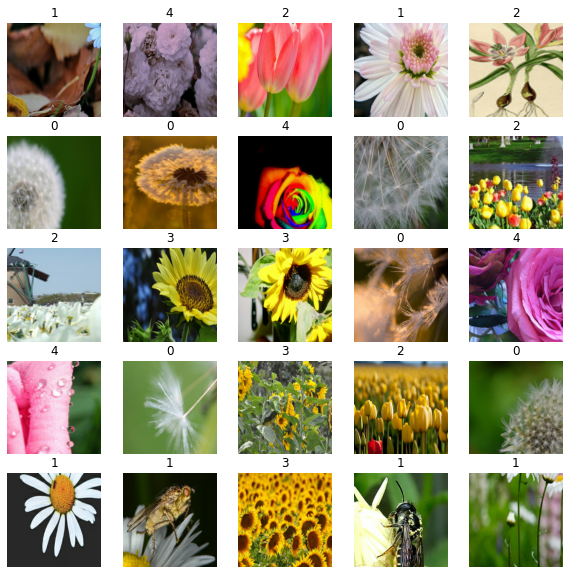

In [7]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

In [8]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [9]:
class MyBiTModel(keras.Model):
  def __init__(self,num_classes,module,**kwargs):
    super().__init__(**kwargs)
    self.num_classes = num_classes
    self.head = keras.layers.Dense(num_classes,kernel_initializer='zeros')
    self.bit_model = module
  def call(self,images):
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes= NUM_CLASSES,module = bit_module)

In [10]:
learning_rate = 0.003*BATCH_SIZE/512

lr_schedule =  keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries =SCHEDULE_BOUNDARIES,
    values =[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,

        
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [11]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/50
10/10 [==============================] - 45s 2s/step - loss: 0.7558 - accuracy: 0.7937 - val_loss: 0.1829 - val_accuracy: 0.9600
Epoch 2/50
10/10 [==============================] - 14s 1s/step - loss: 0.1731 - accuracy: 0.9359 - val_loss: 0.1153 - val_accuracy: 0.9636
Epoch 3/50
10/10 [==============================] - 14s 2s/step - loss: 0.1751 - accuracy: 0.9328 - val_loss: 0.1099 - val_accuracy: 0.9655
Epoch 4/50
10/10 [==============================] - 14s 2s/step - loss: 0.1418 - accuracy: 0.9531 - val_loss: 0.0884 - val_accuracy: 0.9764
Epoch 5/50
10/10 [==============================] - 14s 2s/step - loss: 0.1063 - accuracy: 0.9688 - val_loss: 0.0797 - val_accuracy: 0.9764
Epoch 6/50
10/10 [==============================] - 14s 2s/step - loss: 0.1458 - accuracy: 0.9531 - val_loss: 0.0804 - val_accuracy: 0.9745


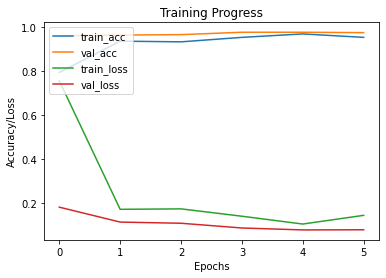

In [12]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [13]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

9/9 [==============================] - 10s 1s/step - loss: 0.0884 - accuracy: 0.9764
Accuracy: 97.64%
